Calculate distances of the hashes

test on: 
(1) random annotation vs shot annotation
(2) trailer vs subset_film vs other_trailer
(3) phash params: hash_size and high_frequency
(4) data augmentation: interlacing, compression, aspect ratio, kleur shift, 

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, hamming, jaccard, cdist
from sklearn.metrics import f1_score as calc_f1
from sklearn.metrics import precision_score, recall_score
# f1_score = calc_f1(y_true, y_pred, labels=None, pos_label=1, average=’binary’, sample_weight=None)
pd.set_option('display.max_rows', 2000)

In [3]:
def load_dataset(dataset_name, film):
    
    def change_hash(dataset_column):
        phashes = list(dataset_column)
        new_phashes = []
        for phash in phashes:
            new_hash = np.array([int(e) for e in phash if e =='0' or e =='1'])
            new_phashes.append(new_hash)
        return new_phashes
    
    loc = globals()['_dh'][0] 
    path_file = loc + '/films/film_{}/hashes/'.format(film) + dataset_name
    with open(path_file) as csvfile:
        dataset = pd.read_csv(csvfile)
    
    columns = []
    for column in dataset.columns:
        if 'hash' in column:
            dataset[column] = change_hash(dataset[column])
    return dataset

def plot_thresholds(title, ax, thresholds, distances, annotations):
    
    min_distances = list(np.amin(distances, axis=1))
    
    def threshold_predictions(min_distances, threshold):
        return [1 if distance < threshold else 0 for distance in min_distances]

    f1_scores = []
    recalls = []
    precisions = []
    y_true = np.array(annotations)
    for threshold in thresholds:
        predictions = threshold_predictions(min_distances, threshold)
        recall = recall_score(y_true, predictions)
        precision = precision_score(y_true, predictions)
        f1_score = calc_f1(y_true, predictions)
        recalls.append(recall)
        precisions.append(precision)    
        f1_scores.append(f1_score)
    ax.plot(thresholds, f1_scores)
    ax.plot(thresholds, recalls)
    ax.plot(thresholds, precisions)
    ax.legend(['f1_score', 'recall', 'precision'], loc='lower left')
    ax.set_title(title)
    
    results = [f1_scores, precisions, recalls]
    return results
    #ax.xlabel('threshold')
    #plt.show()
    

def plot_distances(title, ax, distances):
    ax.imshow(distances)
    ax.set_title(title)

    
def observe_optimal_threshold(results, thresholds):
    list_f1_scores = []
    for result in results:
        f1_scores = result[0]
        list_f1_scores.append(f1_scores)
    all_f1_scores = np.array(list_f1_scores)
    list_f1_scores = list(all_f1_scores.T)
    means = np.mean(all_f1_scores, axis = 0)
    stds = np.round(np.std(all_f1_scores, axis = 0),2)
    df_data = {
        'threshold': thresholds,
        'f1_score_mean': means,
        'f1_score_std': stds,
        'f1_scores': list_f1_scores
    }
    
    df = pd.DataFrame.from_dict(df_data)
    df = df.sort_values(['f1_score_mean', 'f1_score_std'], ascending=[False, True])
    return df
        
        
   

In [5]:
n_film = 1
wd_film = os.getcwd() + '/films/film_{}/film/'.format(n_film)
film = glob.glob(wd_film + '*')[0].split('/')[-1].replace(' ', '-')[0:7]
film = 'SeeFoo'
dataset = load_dataset('{}-hashes-15-4.csv'.format(film), n_film)
dataset_augmented = load_dataset('{}-hashes-15-4-augmented.csv'.format(film), n_film)

In [6]:
trailer_hashes = np.array(list(dataset[dataset['annotation'] == 1].hash))
video_hashes = np.array(list(dataset.hash))

In [ ]:

# distances = cdist(np.array(list(dataset.hash)),trailer_hashes, metric = 'hamming')
# distances_add = cdist(np.array(list(dataset_augmented['hash_add'])), trailer_hashes, metric = 'hamming')
# distances_gauss = cdist(np.array(list(dataset_augmented['hash_gauss'])),trailer_hashes, metric = 'hamming')
# distances_compress = cdist(np.array(list(dataset_augmented['hash_compress'])), trailer_hashes, metric = 'hamming')
# distances_add_csv = cdist(np.array(list(dataset_augmented['hash_add_hsv'])), trailer_hashes, metric = 'hamming')
# distances_constrast = cdist(np.array(list(dataset_augmented['hash_contrast'])), trailer_hashes, metric = 'hamming')
# distances_resize = cdist(np.array(list(dataset_augmented['hash_resize'])), trailer_hashes, metric = 'hamming')


https://github.com/aleju/imgaug

Add(V, PCH)	Adds value V to each image. If PCH is true, then the sampled values may be different per channel.

AdditiveGaussianNoise(L, S, PCH)	Adds white/gaussian noise pixelwise to an image. The noise comes from the normal distribution N(L,S). If PCH is true, then the sampled values may be different per channel (and pixel).

JpegCompression(C)	Applies JPEG compression of strength C (value range: 0 to 100) to an image. Higher values of C lead to more visual artifacts.

AddToHueAndSaturation(V, PCH, F, C)	Adds value V to each pixel in HSV space (i.e. modifying hue and saturation). Converts from colorspace F to HSV (default is F=RGB). Selects channels C before augmenting (default is C=[0,1]). If PCH is true, then the sampled values may be different per channel.

GammaContrast(G, PCH)	Applies gamma contrast adjustment following I_ij' = I_ij**G', where G' is a gamma value sampled from G and I_ij a pixel (converted to 0 to 1.0 space). If PCH is true, a different G' is sampled per image and channel.

PerspectiveTransform(S, KS)	Applies a random four-point perspective transform to the image (kinda like an advanced form of cropping). Each point has a random distance from the image corner, derived from a normal distribution with sigma S. If KS is set to True (default), each image will be resized back to its original size.

Resize(S, I)	Resizes images to size S. Common use case would be to use S={"height":H, "width":W} to resize all images to shape HxW. H and W may be floats (e.g. resize to 50% of original size). Either H or W may be "keep-aspect-ratio" to define only one side's new size and resize the other side correspondingly. I is the interpolation to use (default: cubic).

In [8]:
distances = cdist(np.array(list(dataset_augmented['hash_add'])),trailer_hashes, metric = 'hamming')

In [9]:
min_distances = list(np.amin(distances, axis=1))
predictions = [1 if distance < 0.07 else 0 for distance in min_distances]
dataset['predictions'] = predictions

In [12]:
dataset[dataset['Unnamed: 0'] > 833]

,Unnamed: 0,video_name,frame,hash,annotation,predictions
834,834,SeeFoo,frame0834.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0,0
835,835,SeeFoo,frame0835.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0,0
836,836,SeeFoo,frame0836.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0,0
837,837,SeeFoo,frame0837.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0,1
838,838,SeeFoo,frame0838.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0,1
839,839,SeeFoo,frame0839.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",0,1
840,840,SeeFoo,frame0840.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",1,1
841,841,SeeFoo,frame0841.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",1,1
842,842,SeeFoo,frame0842.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",1,1
843,843,SeeFoo,frame0843.jpg,"[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, ...",1,1


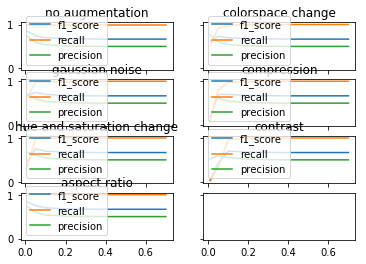

In [18]:
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex=True, sharey=True)
results1 = plot_thresholds('no augmentation', ax1, thresholds, cdist(np.array(list(dataset.hash)),trailer_hashes, metric = 'hamming'), dataset.annotation)
results2 = plot_thresholds('colorspace change', ax2, thresholds, cdist(np.array(list(dataset_augmented['hash_add'])),trailer_hashes, metric = 'hamming'), dataset.annotation)
results3 = plot_thresholds('gaussian noise', ax3, thresholds, cdist(np.array(list(dataset_augmented['hash_gauss'])), trailer_hashes, metric = 'hamming'), dataset.annotation)
results4 = plot_thresholds('compression', ax4, thresholds, cdist(np.array(list(dataset_augmented['hash_compress'])), trailer_hashes, metric = 'hamming'), dataset.annotation)
results5 = plot_thresholds('hue and saturation change', ax5, thresholds, cdist(np.array(list(dataset_augmented['hash_add_hsv'])),trailer_hashes, metric = 'hamming'), dataset.annotation)
results6 = plot_thresholds('contrast', ax6, thresholds, cdist(np.array(list(dataset_augmented['hash_contrast'])),trailer_hashes, metric = 'hamming'), dataset.annotation)
results7 = plot_thresholds('aspect ratio', ax7, thresholds, cdist(np.array(list(dataset_augmented['hash_resize'])), trailer_hashes, metric = 'hamming'), dataset.annotation)

fig.set_size_inches(18.5, 10.5)
fig.savefig('thresholds_{}'.format(film))


In [26]:
results = [results1, results2, results3, results4, results5, results6, results7]
df = get_optimal_threshold(results, thresholds)

In [67]:
df

In [ ]:
plt.rcParams['figure.figsize'] = [10, 20]

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, sharex=True, sharey=True)

plot_distances('no augmentation', ax1,  distances)
plot_distances('colorspace change', ax2,  distances_add)
plot_distances('gaussian noise', ax3,  distances_gauss)
plot_distances('compression', ax4,  distances_compress)
plot_distances('hue and saturation change', ax5,  distances_add_csv)
plot_distances('contrast', ax6,  distances_constrast)
plot_distances('aspect ratio', ax7,  distances_resize)

fig.savefig('distances')